Ejercicio 1
--

Primeramente cargamos las funciones definidas en modelo.py: carga de imagen, preprocesamiento (que la convierte a en un tensor de floats) y generacion de label

In [1]:
import os
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

In [2]:
def load_image(path='../assets/test_image.jpg'):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_image(image_raw)
    return image

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

Aquí creo una función que muestre la imagen usando el código de modelo.py. Esta función sera llamada varias veces durante el ejercicio

In [3]:
def plotImage(image, probs):
    # This plots the results
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    _, image_class, class_confidence = get_imagenet_label(probs)
    result = '{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)
    print(result)
    plt.title(result)
    plt.show()

Entrenamos la imagen original y observamos su resultado

Labrador_retriever : 50.60% Confidence


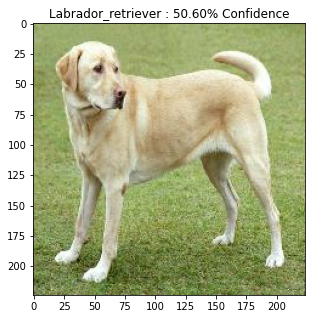

In [4]:
# This loads and saves the model
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False
model.save('assets/model.h5')

# This loads the image and classify it
image = load_image()
image = preprocess(image)
probs = model.predict(image)

#print(image)

plotImage(image, probs)

Como indicado en el ejercicio 1. Vamos a crear un método de alteración de la imagen, el cuál sea invisible al ojo humano pero que consiga engañar al modelo mobilnet propuesto en el ejercicio. 
Uno de los métodos más conocidos en la literatura es el "Método de signo de gradiente rápido". Con este método vamos a distorsionar la imagen original aplicándole perturbaciones que confundan a la red neuronal y de como resultado una imagen contradictoria. 

El método de signo de gradiente rápido emplea los gradientes de la NN para generar perturbación. 
Dada una imagen, este método emplea los gradientes de la loss (función de pérdida de la red) con respecto a la imagen de entrada para generar una nueva imagen, la cuál maximice dicha pérdida. 

En primer lugar vamos a generar las perturbaciones usando la función generate_adversarial_alteration que toma como entrada una imgaen y su label:

In [5]:
def generate_adversarial_alteration(image, label, lossFunc):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image) #inferencia
    loss = lossFunc(label, prediction) #calculo la loss    
  grad = tape.gradient(loss, image) #calculo el gradiente de la loss para la imagen  
  signed_grad = tf.sign(grad) #aplico la funcion sign 
  return signed_grad


Ahora llamamos a la función. Usamos la función de loss CategoricalCrossentropy que es la empleada en clasificación. Vamos a pintar las perturbaciones: al ojo humano no dicen mucho, pero vamos a ver como sí van a influenciar bastante en el modelo.

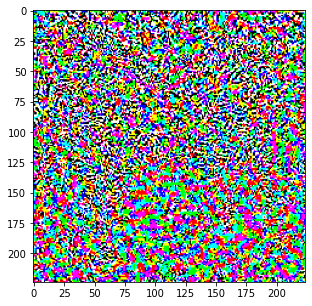

In [6]:
#extraigo la label y la transformo al formato esperado por el modelo 
index_labrador = 208 #el indice para esa etiqueta en concreto
label = tf.one_hot(index_labrador, probs.shape[-1]) #
label = tf.reshape(label, (1, probs.shape[-1]))

#genero las perturbaciones
lossFunc = tf.keras.losses.CategoricalCrossentropy()#funcion de loss usada pues es un problema de clasificicon
perturbations = generate_adversarial_alteration(image, label, lossFunc)

# las pinto 
plt.imshow(perturbations[0] * 0.5 + 0.5);

En la función de preprocesamiento dada en el ejercicio, la imagen se convierte en un tensor de floats, es decir hemos pasado de tener la imagen en rango [0,255] a [-1,1]. 
Para poder cumplir con el requisito pedido por el ejercicio en el que nos piden no alterar en más de una unidad cada píxel (en rango [0,255]), debemos calcular la alteración equivalente de la salida de la imagen preprocesada ([-1,1]) a la escala original (en 255). 
Dicha alteración no debe superar pues una unidad. floatToUint8 toma como entrada la diferencia en valor absoluto entre dos imágenes preprocesadas y calcula su proporcion si dichas imágenes estuvieran en rango [0,255]

In [7]:
def floatToUint8(image):
    const = 255/2 #porque está en [-1,1]
    return (image*const)

Vamos a experimentar con varios valores del parámetro epsilon y observar el resultado de la clasificación del modelo y de la alteración de la imagen. Epsilon es un multiplicador que se usa para asegurar que las perturbaciones sean pequeñas.
Después de probar con varios valores, he dejado lo valores de epsilon más representativos y que no modifican la imagen en más de una unidad cada píxel.
Maximum pixel alteration debe ser como máximo 1, pues es la alteración real que cada píxel estaría sufriendo.


 ------------------------ 
Epsilon:  0
Maximum pixel alteration in range [0,255]:  tf.Tensor(0.0, shape=(), dtype=float32)
Labrador_retriever : 50.60% Confidence


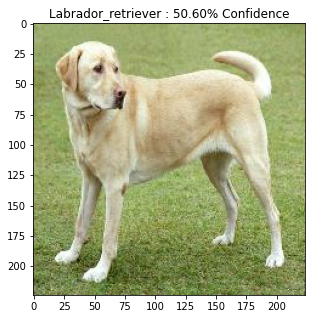

 ------------------------ 
Epsilon:  0.001
Maximum pixel alteration in range [0,255]:  tf.Tensor(0.12750027, shape=(), dtype=float32)
Labrador_retriever : 20.41% Confidence


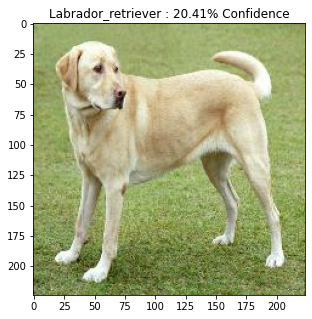

 ------------------------ 
Epsilon:  0.005
Maximum pixel alteration in range [0,255]:  tf.Tensor(0.63750035, shape=(), dtype=float32)
Saluki : 13.93% Confidence


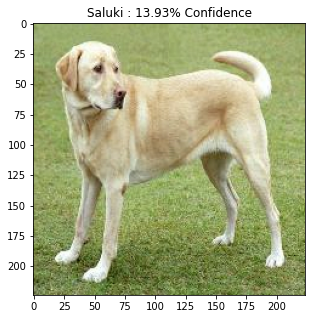

 ------------------------ 
Epsilon:  0.0075
Maximum pixel alteration in range [0,255]:  tf.Tensor(0.95625, shape=(), dtype=float32)
Saluki : 15.91% Confidence


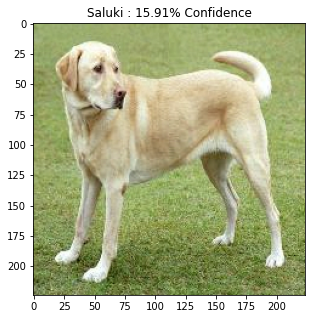

In [8]:
epsilons = [0,0.001,0.005,0.0075] # mas de 0.01 no respeta la restriccion impuesta por el ejercicio pues anade mas de 1 al pixel
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, epsilon in enumerate(epsilons):
    adv_image = image + (epsilon*perturbations)
    adv_image = tf.clip_by_value(adv_image, -1, 1)
    max_abs = tf.reduce_max(tf.abs(image-adv_image))
    
    print(" ------------------------ ")
    print("Epsilon: ", epsilon)
    print("Maximum pixel alteration in range [0,255]: ", floatToUint8(max_abs) )
    
    # Llama al modelo para que clasifique la imagen pasada por parametro    
    adv_probs = model.predict(adv_image)
    #Imprimo la imagen y su clasificacion
    plotImage(adv_image, adv_probs)


Podemos observar que a medida que epsilon aumenta, más fácil es engañar a la NN, y más evidentes al ojo humano se muestran dichas perturbaciones.

Un resultado con un epsilon de 0.0075 parece el más adecuado pues altera la imagen que consigue engañar al modelo haciéndolo creer que el labrador es un Saluki (una raza de perro que por cierto no conocía) con un grado de confianza del 16%. El píxel con la máxima no llega a una unidad (0.95) cumpliendo así con la restricción impuesta por el ejercicio.